Advanced Lane Finding
===========================

## Computer Vision & Robotics

Robotics can essentially be broken down into a three step cycle:
- Sense or perceive the world.
- Decide what to do based on that perception.
- Perform an action to carry out that decision.

Computer vision is a major part of the perception step in that cycle.
Computer vision is the art and science of perceiving and understanding the world around you through images. 

In the case of self-driving cars, computer vision helps us:
- detect lane markings, vehicles, pedestrians, and other elements in the environment.
- Navigate safely.

The main focus of this topic is:
- advanced lane-finding
- vehicle detection and tracking

### Getting Started with Camera Calibration

For example: to steer a car:
- You need to measure how much your lane is curving.
- You need to get perspective transformation from front view to birds-eye view.
- Correct for effect of image distortion.
 - Changes shape and size of objects.
 
 
#### Distrortion

<img src="assets/18-1.png">
Image distortion occurs when a camera looks at 3D objects in the real world and transforms them into a 2D image; this transformation isn’t perfect. Distortion actually changes what the shape and size of these 3D objects appear to be. So, the first step in analyzing camera images, is to undo this distortion so that you can get correct and useful information out of them.

Today’s cheap pinhole cameras introduces a lot of distortion to images. 
Two major distortions are:
- radial distortion and 
- tangential distortion.


**Radial distortion:**
Real cameras use curved lenses to form an image, and light rays often bend a little too much or too little at the edges of these lenses. This creates an effect that distorts the edges of images, so that lines or objects appear more or less curved than they actually are. This is called radial distortion, and it’s the most common type of distortion.
- Fisheye lenses use radial distortion for a stylistic effect.
<img src="assets/18-2.PNG">



**Tangential distortion:**
This occurs when a camera’s lens is not aligned perfectly parallel to the imaging plane, where the camera film or sensor is. This makes an image look tilted so that some objects appear farther away or closer than they actually are.
<img src="assets/18-3.PNG">


#### Distortion Coefficients and Correction
There are three coefficients needed to correct for **radial distortion: k1, k2, and k3**. To correct the appearance of radially distorted points in an image, one can use a correction formula:

$$x_{corrected} = x(1+k_1r^2+k_2r^4+k_3r^6)$$
$$y_{corrected} = y(1+k_1r^2+k_2r^4+k_3r^6)$$

$(x,y)$ is a point in a distorted image.  To undistort these points, OpenCV calculates r, which is the known distance between a point in an undistorted (corrected) image.

$$r=\left \| (x_{corrected}, y_{corrected})- (x_c, y_c) \right \|$$

where $(x_c, y_c)$ is the **distortion center**, the center of the image distortion. 
<img src="assets/18-4.png">

----------------------------------

There are two more coefficients that account for **tangential distortion: p1 and p2**, and this distortion can be corrected using a different correction formula:
$$x_{corrected} = x + [2p_1xy + p_2(r^2 + 2x^2)]$$
$$y_{corrected} = y + [p_1(r^2+2y^2)+2p_2xy]$$

In short, we need to find five parameters, known as distortion coefficients given by:
$$\text{Distortion coefficient} = (k_1, k_2, p_1, p_2, k_3)$$


In addition to this, we need to find a few more information, like intrinsic and extrinsic parameters of a camera.


Intrinsic parameter includes information like focal length($f_x$, $f_y$), optical centers ($c_x$, $c_y$). It is also called camera matrix. It depends on the camera only, so once calculated, it can be stored for future purposes. It is expressed as a 3x3 matrix:
$$\text{camera matrix}=\begin{bmatrix}
f_x & 0  & c_x\\ 
0 & f_y & c_y\\ 
0 & 0 & 1
\end{bmatrix}$$


Extrinsic parameters corresponds to rotation and translation vectors which translates a coordinates of a 3D point to a coordinate system.<sup>[1]</sup>




### Calibrating our camera

#### Basics

1. Take pictures of known shapes to calibrate our camera. E.g. a chessboard (a regular, high-contrast pattern).

  - Recommended to use at least 20 images for calibration. Images taken at different angles and distances.
    
  - Include a test image.
       
2. Store the object and image points from each image.
 -  Important input datas needed for camera calibration is a set of 3D real world points and its corresponding 2D image points. 2D image points are OK which we can easily find from the image. (These image points are locations where two black squares touch each other in chess boards)
 - 3D points are called object points and 2D image points are called image points.
    - E.g. for a 7 row by 9 column chessboard:![](assets/18-9.png)
    
3. Find pattern in chess board, we use the function, ``` cv2.findChessboardCorners()```.
  - We also need to pass what kind of pattern we are looking, like 8x8 grid, 5x5 grid etc. In this example, we use 7x6 grid. (Normally a chess board has 8x8 squares and 7x7 internal corners). It returns the corner points and retval which will be True if pattern is obtained. These corners will be placed in an order (from left-to-right, top-to-bottom)
  - Once we find the corners, we can increase their accuracy using ```cv2.cornerSubPix()```. We can also draw the pattern using ```cv2.drawChessboardCorners()```. 
   


In [1]:
# Import Packages
import matplotlib
matplotlib.use("Qt5Agg")
%matplotlib qt5
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
matplotlib.__version__

'2.0.0'

In [3]:
import numpy as np
import cv2
import glob

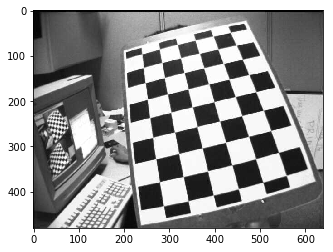

In [4]:
# Read in a calibration image
img = cv2.imread('images/left05.jpg')
plt.imshow(img)

In [5]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 
            30, 0.001)

In [6]:
# Arrays to store object points and image points from all the images
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Prepare object pionts, like(0, 0, 0), (1, 0, 0) , (2,0,0) ..,(6,5,0)
objp = np.zeros((6*8, 3), np.float32)
objp[:, :2] = np.mgrid[0:8, 0:6].T.reshape(-1, 2) # x, y coordinates

images = glob.glob('images/*.jpg')


In [7]:
%matplotlib qt5
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        
        cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
        plt.imshow(img)
        

#### Calibration
Now that we have our object points and image points we are ready to go for calibration. For that we use the function, ```cv2.calibrateCamera()```. It returns the camera matrix, distortion coefficients, rotation and translation vectors etc.

- ```gray.shape[::-1]```: Shape of the image
- ```dist```: distortion coefficient
- ```mtx```: Camera matrix
- ```rvecs```, ```tvecs```: position of camera in the world

In [8]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints, 
                                                   gray.shape[::-1],
                                                   None,None)

#### Undistortion

We have got what we were trying. Now we can take an image and undistort it. OpenCV comes with two methods.
But before that, we can refine the camera matrix based on a free scaling parameter using ```cv2.getOptimalNewCameraMatrix()```. 

If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. It also returns an image ROI which can be used to crop the result.

So we take a new image (left05.jpg in this case. That is the first image in this chapter)

In [9]:
img = cv2.imread('images/left05.jpg')
h,  w = img.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,
                                                (w,h),1,
                                                (w,h))

#### 1. Using ```cv2.undistort()```
This is the shortest path. Just call the function and use ROI obtained above to crop the result.

In [10]:
# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx) 
# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png',dst)

True

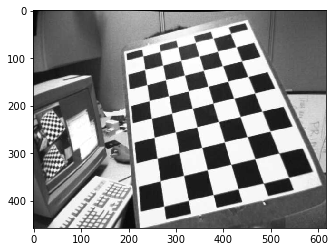

In [11]:
%matplotlib inline
image_ = plt.imread('calibresult.png')
plt.imshow(image_)

#### 2. Using remapping
This is curved path. First find a mapping function from distorted image to undistorted image. Then use the remap function.

In [12]:
# undistort
mapx,mapy = cv2.initUndistortRectifyMap(mtx,dist,None,
                                        newcameramtx,(w,h),5)
dst = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)
# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult1.png',dst)

True

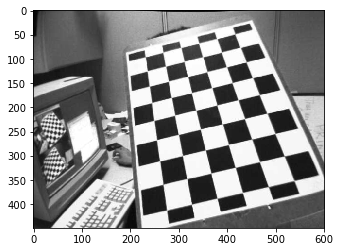

In [13]:
image_ = plt.imread('calibresult1.png')
plt.imshow(image_)

Both the methods give the same result. In the result that all the edges are straight.

Now we can store the camera matrix and distortion coefficients using write functions in Numpy (```np.savez```, ```np.savetxt``` etc) for future uses.

### Re-projection Error

Re-projection error gives a good estimation of just how exact is the found parameters. This should be as close to zero as possible. Given the intrinsic, distortion, rotation and translation matrices, we first transform the object point to image point using ```cv2.projectPoints()```. Then we calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error we calculate the arithmetical mean of the errors calculate for all the calibration images.

In [14]:
mean_error = 0
tot_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    tot_error += error
print ("total error: ", mean_error/len(objpoints))

total error:  0.0


## Extracting information from images of the road

## Lane Curvature
Why: Self-driving cars need to be told the correct steering angle to turn

Process: 

1. Detect lane lines using masking and thresholding techniques.
     * <img src="assets/18-11.png" height="400px">
     
2. Perform perspective transform to get birds' eye view of the lane.
     * <img src="assets/18-12.png" height="400px">

3. Fit polynomial to lane line $f(y) = Ay^2 + By + C$.
  - A gives you the curvature of the lane lines
  - B gives you the heading or direction that the line is pointing, and
  - C gives you the position of the line based on how far away it is from the very left of an image (y=0).

4. Extract curvature of lane lines using a mapping.
     * <img src="assets/18-13.png" height="400px">
     
  


## Perspective transform 

- Changes apparent perspective.
- Maps the points in a given image to different, desired, image points with a new perspective.

<img src="assets/18-16.png" height="400px">

Examples of perspective:
<img src="assets/18-14.png" height="400px">

<img src="assets/18-15.png" height="400px">


Birds eye view also allows us to map a car's location to e.g. Google Maps.

<img src="assets/18-17.png" height="400px">

<img src="assets/18-18.png" height="400px">



For perspective transformation, we need a 3x3 transformation matrix. Straight lines will remain straight even after the transformation. 

To find this transformation matrix, we need 4 points on the input image and corresponding points on the output image. Among these 4 points, 3 of them should not be collinear. Then transformation matrix can be found by the function ```cv2.getPerspectiveTransform```. Then apply ```cv2.warpPerspective``` with this 3x3 transformation matrix.

![](assets/18-20.png)


----------------------------------

![](assets/18-21.png)


In [15]:
img = mpimg.imread('assets/stop.jpeg')
%matplotlib qt5
plt.imshow(img)

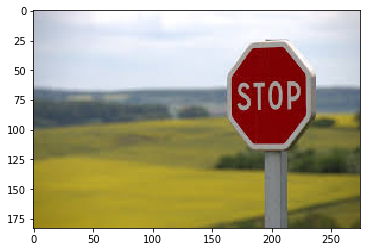

In [16]:
%matplotlib inline
plt.imshow(img)

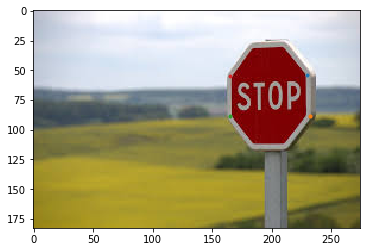

In [17]:
# Source image points

plt.imshow(img)
plt.plot(230, 54, '.')  # top right
plt.plot(232, 88, '.')  # bottom right
plt.plot(165, 88, '.')  # bottom left
plt.plot(165, 55, '.')  # top left


In [18]:
# define perspective transform function
def warp(img):
    
    # Define calibration box in source (original) and destination
    # (desired or warped) coordinates
    
    rows, cols, ch = img.shape
    
    # Four source coordinates
    src = np.float32(
                   [[230, 54],
                    [232, 88],
                    [165, 88],
                    [165, 55]])
    
    # Four desired coordinates
    dst = np.float32(
                    [[150, 50],
                     [150, 90],
                     [120, 90],
                     [120, 50]])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Could compute the inverse also by swapping the input 
    # parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # create warped image - Uses linear interpolation
    warped = cv2.warpPerspective(img, M , (rows, cols), 
                                 flags=cv2.INTER_LINEAR)
    
    return warped


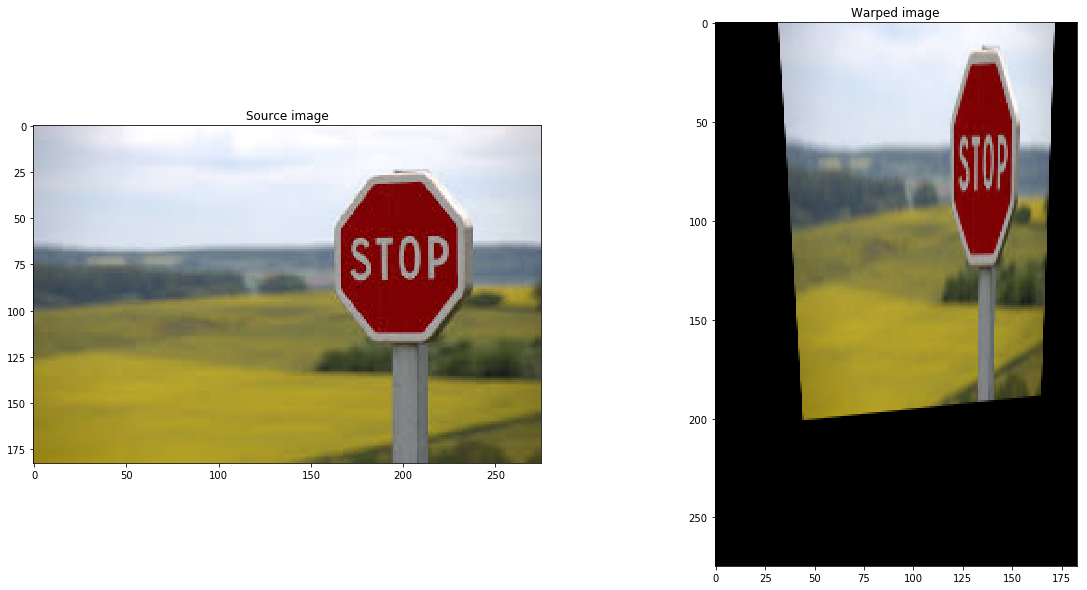

In [19]:
# Get perspective transform 
warped_img = warp(img)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Source image')
ax1.imshow(img)

ax2.set_title('Warped image')
ax2.imshow(warped_img)

plt.show()

In [20]:
%matplotlib qt5
plt.imshow(warped_img)

References:
- <sup>[1]</sup> [OpenCV Docs: Camera Calibration](http://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)